# Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
import zipfile
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Разведовочный анализ данных

## train

In [2]:
# Загрузим тренировочные данные
df_train = pd.read_csv('train.csv', index_col=0)
df_train

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


In [3]:
# Размерность данных
df_train.shape

(37518, 3)

In [4]:
# Информация о данных
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  37518 non-null  int64 
 1   ts       37518 non-null  object
 2   gate_id  37518 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [5]:
# Поиск дубликатов
columns_except_user_id = df_train.columns[df_train.columns != 'user_id'].tolist()
df_train[df_train.duplicated(keep='first')].sort_values(by=columns_except_user_id)

,user_id,ts,gate_id
2,18,2022-07-29 09:09:54,9
11,18,2022-07-29 09:33:23,9
16,1,2022-07-29 09:34:18,9
22,3,2022-07-29 09:42:49,9
30,6,2022-07-29 09:54:25,9
...,...,...,...
37494,32,2022-12-30 19:33:04,9
37499,54,2022-12-30 19:47:21,9
37506,29,2022-12-30 20:35:06,9
37509,6,2022-12-31 17:20:40,9


В данных найдены дубликаты. Вероятнне всего были какие-то сбои или баги в системе связанной с турникетами, поэтому появились дубликаты. Для дальнейшего анализа данных и обучения модели, было решено удалить дубликаты.

In [6]:
# Удалим дубликаты из train
columns_except_user_id = df_train.columns[df_train.columns != 'user_id'].tolist()
df_train = df_train.drop_duplicates(subset=columns_except_user_id, keep='first')

In [7]:
print('Количество уникальных gate_id в train:', df_train['gate_id'].nunique())
sorted(df_train['gate_id'].unique())

Количество уникальных gate_id в train: 17


[-1, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [8]:
print('Количество уникальных user_id в train:', df_train['user_id'].nunique())
print(sorted(df_train['user_id'].unique()))

Количество уникальных user_id в train: 56
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [9]:
# Подсчитываем количество записей для каждого user_id
count_df = df_train['user_id'].value_counts().reset_index()
count_df.columns = ['user_id', 'count']
sorted_count_df = count_df.sort_values(by='count', ascending=False)
sorted_count_df

,user_id,count
0,37,2180
1,55,2161
2,6,1854
3,12,1837
4,19,1661
5,15,1659
6,18,1439
7,53,1277
8,11,1251
9,47,1248


### Графики

In [10]:
# Преобразуем столбец ts в формат datetime для удобного анализа данных
df_train['ts'] = pd.to_datetime(df_train['ts'])

Код ниже применялся для построения графиков передвижений user_id. Данные графики строились с целью найти визуально зависимсоти между перемещениями в train и test. Чтобы не перегружать ноутбук данная часть кода была закомментирована и в качестве примера выводится график для первого user_id.

In [11]:
# # Построим графики передвижений user_id
# unique_users = df_train['user_id'].unique()
# unique_users.sort()

# fig, axes = plt.subplots(len(unique_users), 1, figsize=(20, 6 * len(unique_users)), sharex=True)

# for ax, user_id in zip(axes, unique_users):
#     user_data = df_train[df_train['user_id'] == user_id]
#     ax.plot(user_data['ts'], user_data['gate_id'], marker='o', label=f'User {user_id}')
#     ax.set_xlabel('Timestamp')
#     ax.set_ylabel('Gate ID')
#     ax.set_title(f'Зависимость между ts и gate_id для User {user_id}')
#     ax.legend()
#     ax.grid(True)

# plt.tight_layout()
# plt.show()

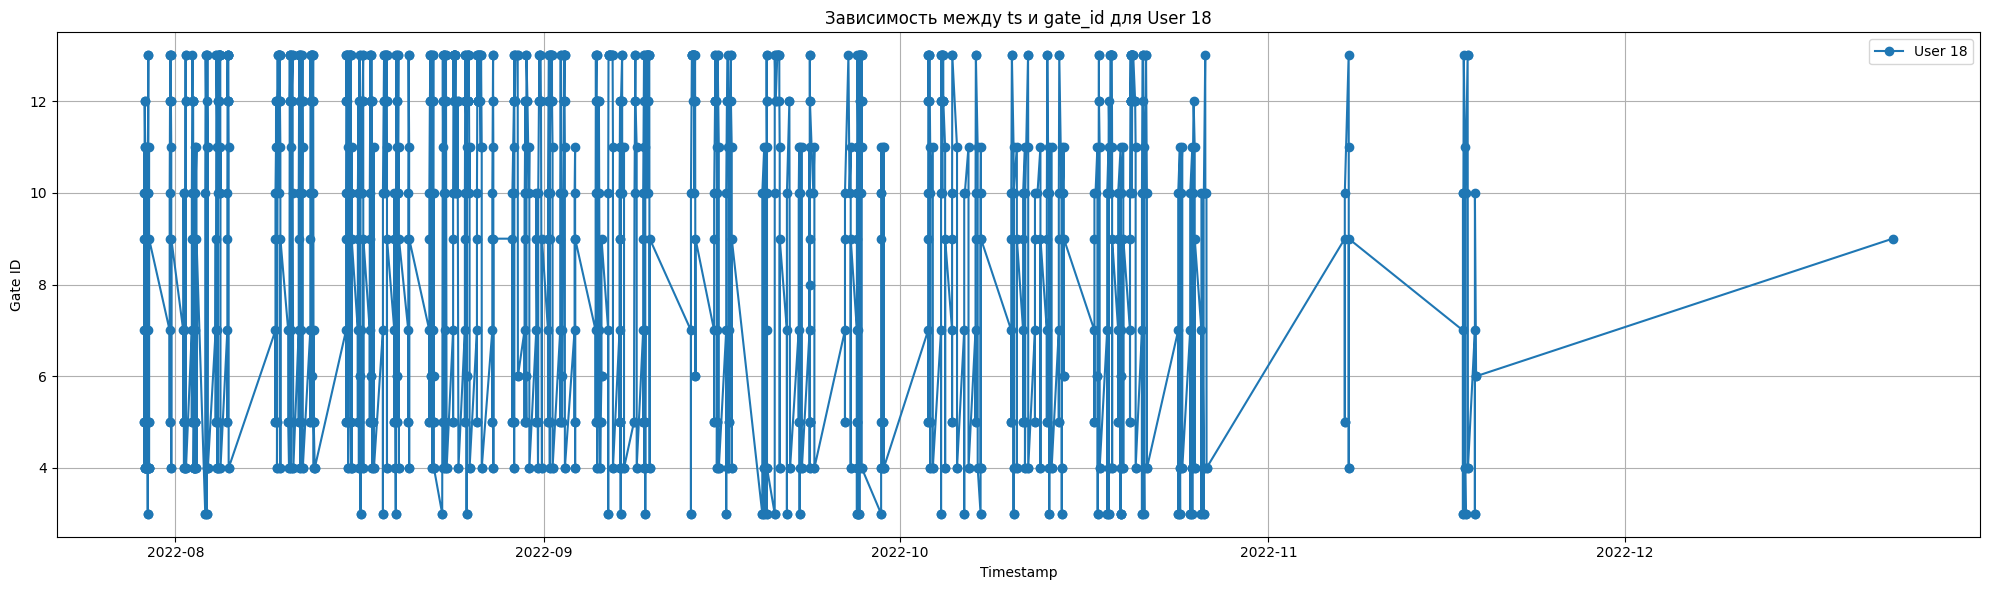

In [12]:
# Построим график передвижений для первого user_id для примера
unique_users = df_train['user_id'].unique()
first_user_id = unique_users[0]

fig, ax = plt.subplots(figsize=(20, 6))

user_data = df_train[df_train['user_id'] == first_user_id]
ax.plot(user_data['ts'], user_data['gate_id'], marker='o', label=f'User {first_user_id}')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Gate ID')
ax.set_title(f'Зависимость между ts и gate_id для User {first_user_id}')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

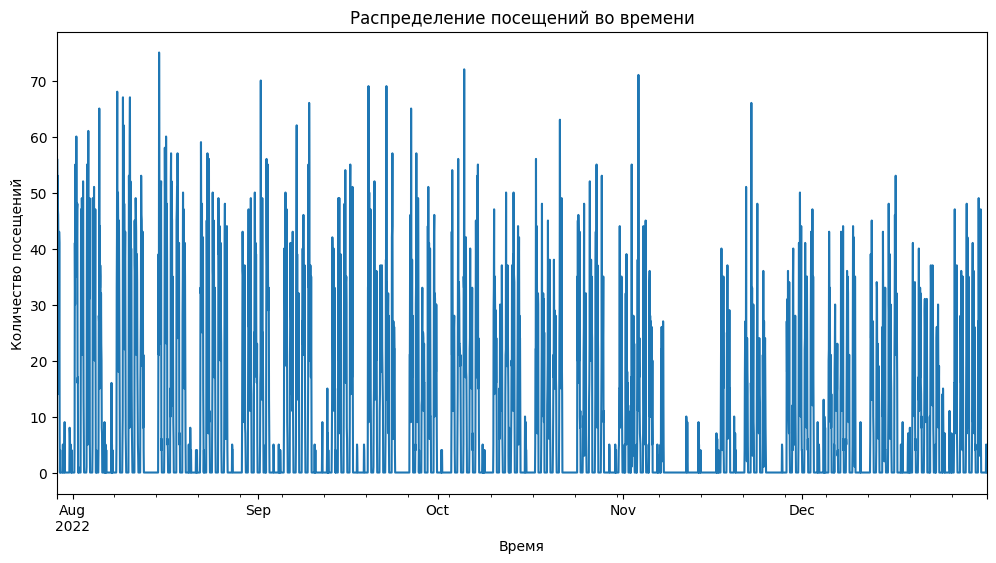

In [13]:
# График распределения посещений во времени
plt.figure(figsize=(12, 6))
df_train.set_index('ts').resample('H').size().plot()
plt.title('Распределение посещений во времени')
plt.xlabel('Время')
plt.ylabel('Количество посещений')
plt.show()

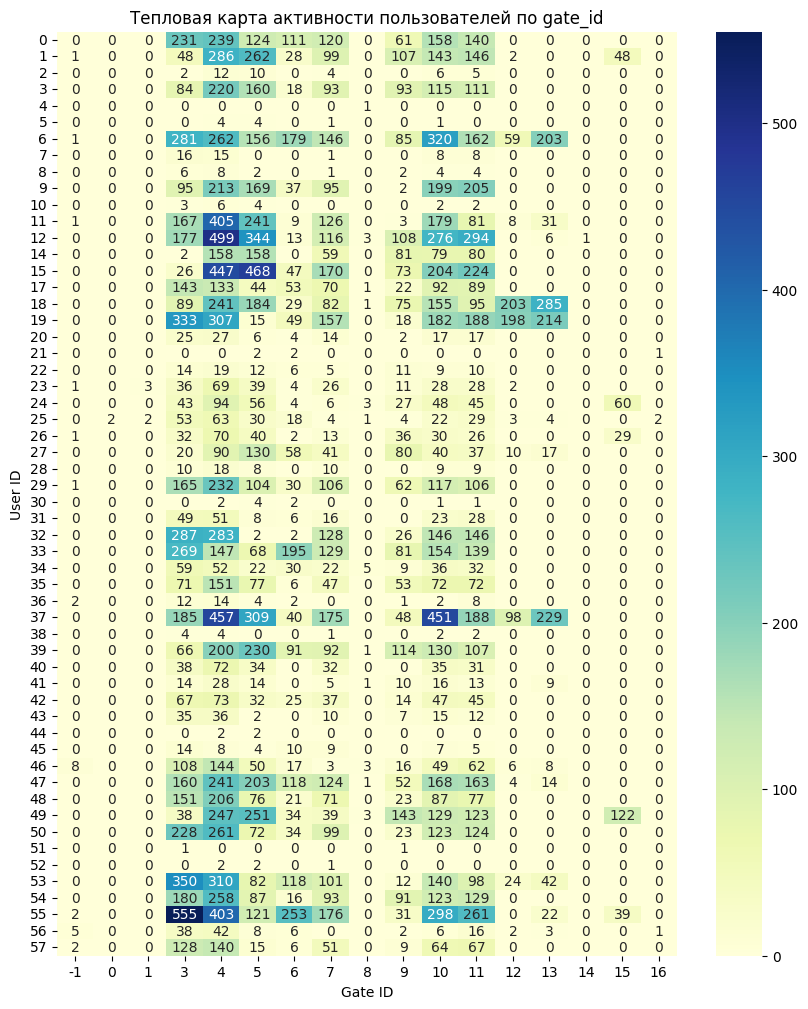

In [14]:
# Тепловая карта активности пользователей по gate_id
heatmap_data_gate = df_train.pivot_table(index='user_id', columns='gate_id', values='ts', aggfunc='count', fill_value=0)
plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data_gate, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по gate_id')
plt.xlabel('Gate ID')
plt.ylabel('User ID')
plt.show()

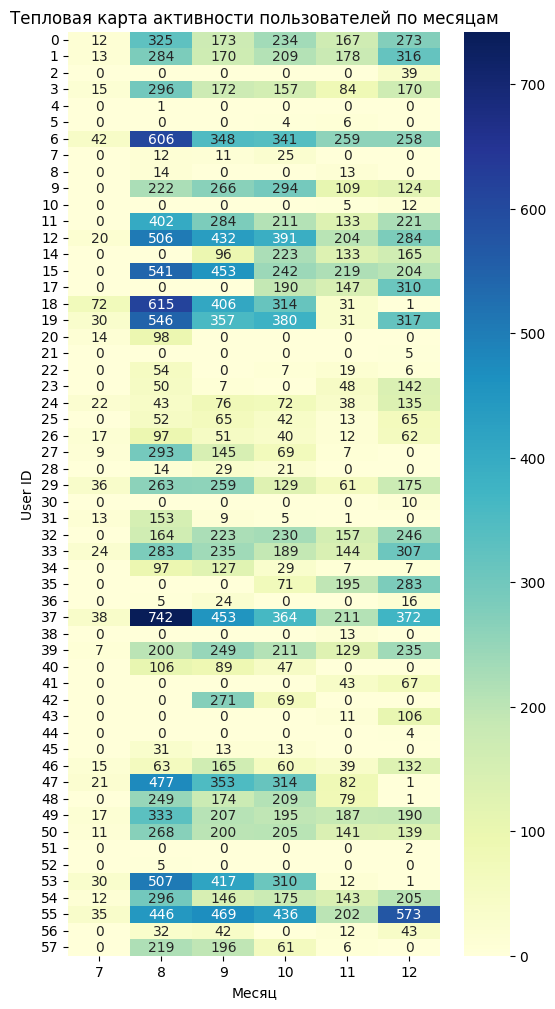

In [15]:
# Тепловая карта активности пользователей по месяцам
heatmap_data_month = df_train.pivot_table(index='user_id', columns=df_train['ts'].dt.month, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(6, 12))
sns.heatmap(heatmap_data_month, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('User ID')
plt.show()

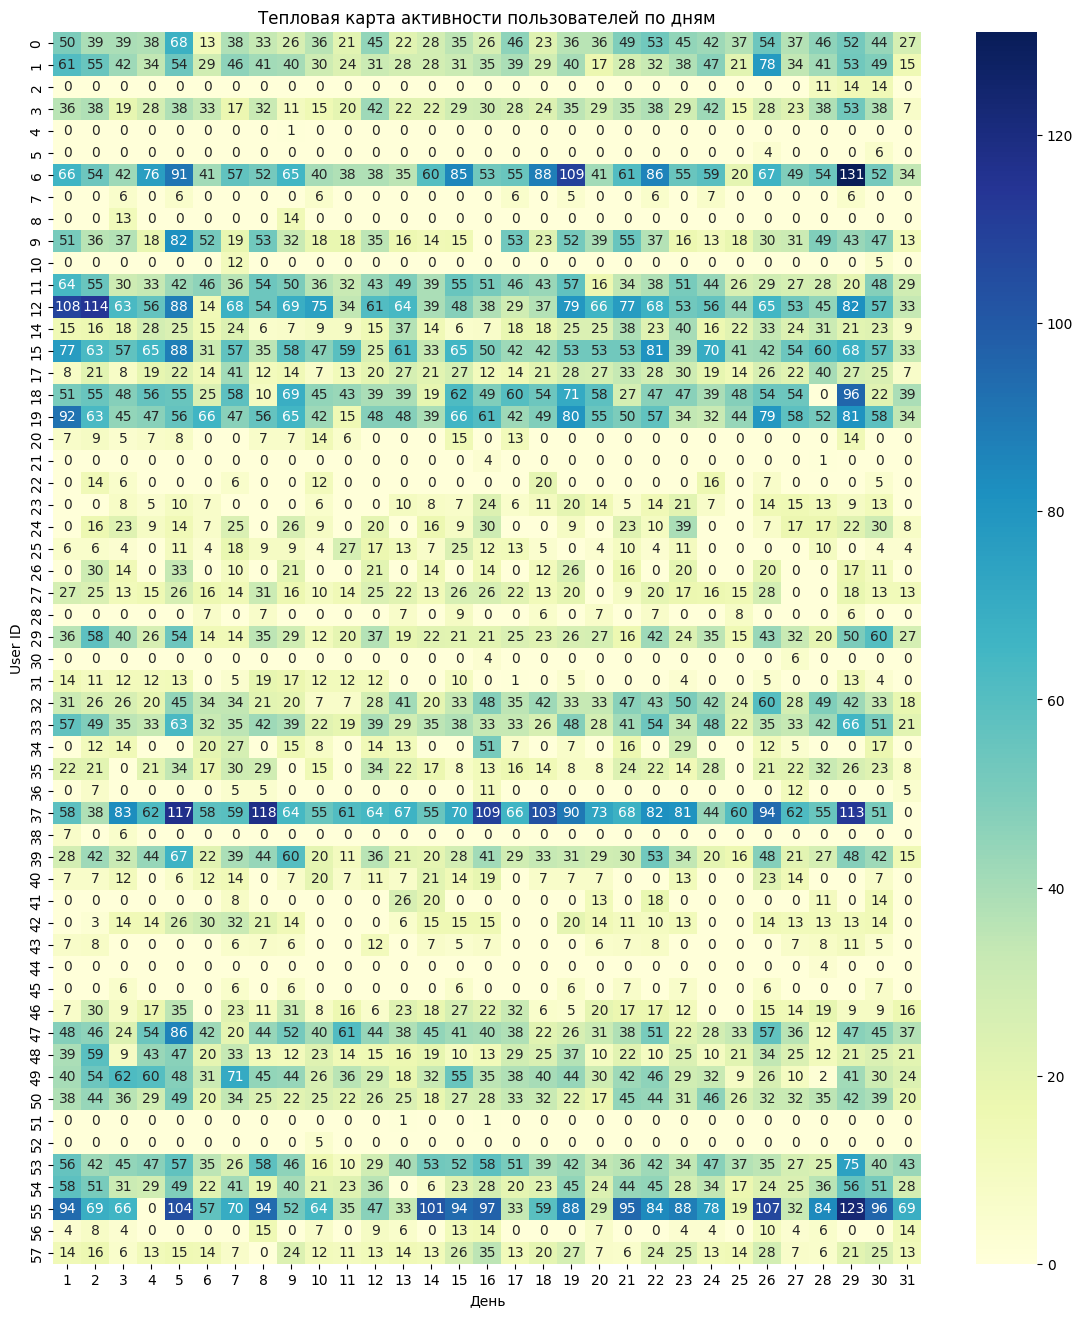

In [16]:
heatmap_data_day = df_train.pivot_table(index='user_id', columns=df_train['ts'].dt.day, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(14, 16))
sns.heatmap(heatmap_data_day, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по дням')
plt.xlabel('День')
plt.ylabel('User ID')
plt.show()

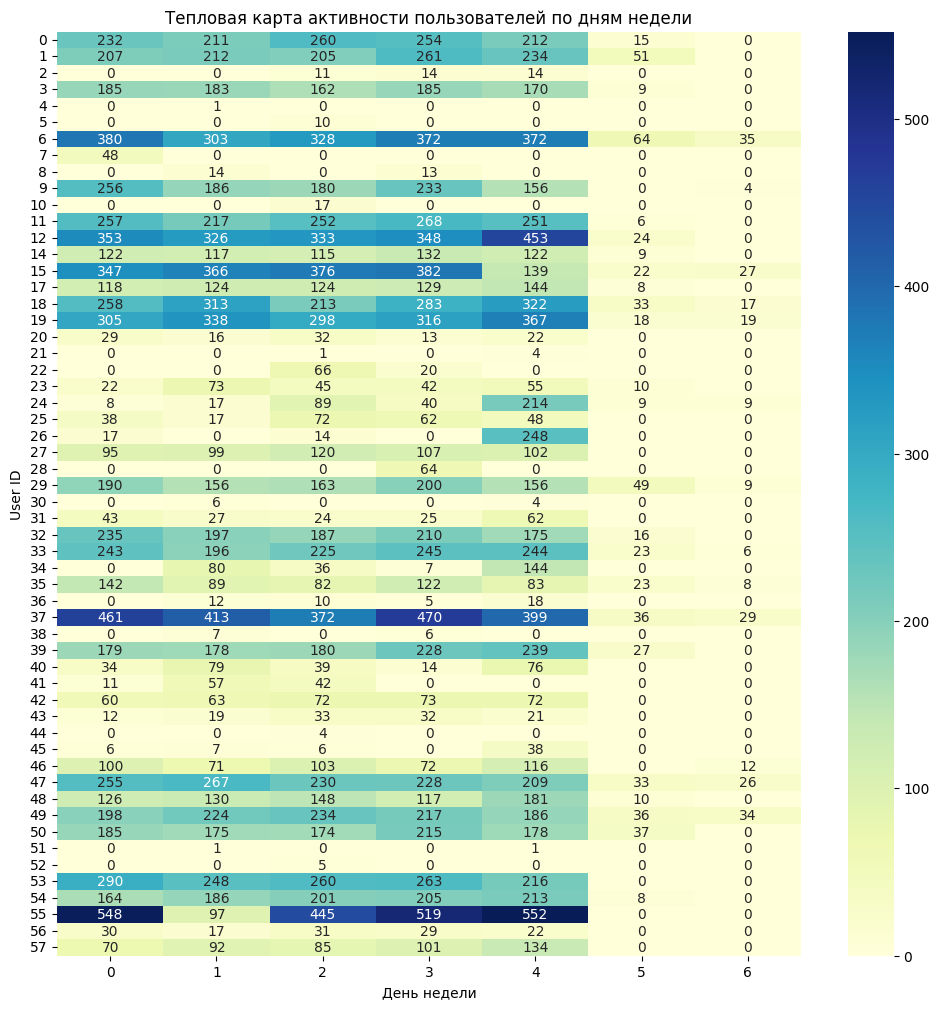

In [17]:
# Тепловая карта активности пользователей по дням недели
heatmap_data_weekday = df_train.pivot_table(index='user_id', columns=df_train['ts'].dt.dayofweek, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data_weekday, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по дням недели')
plt.xlabel('День недели')
plt.ylabel('User ID')
plt.show()

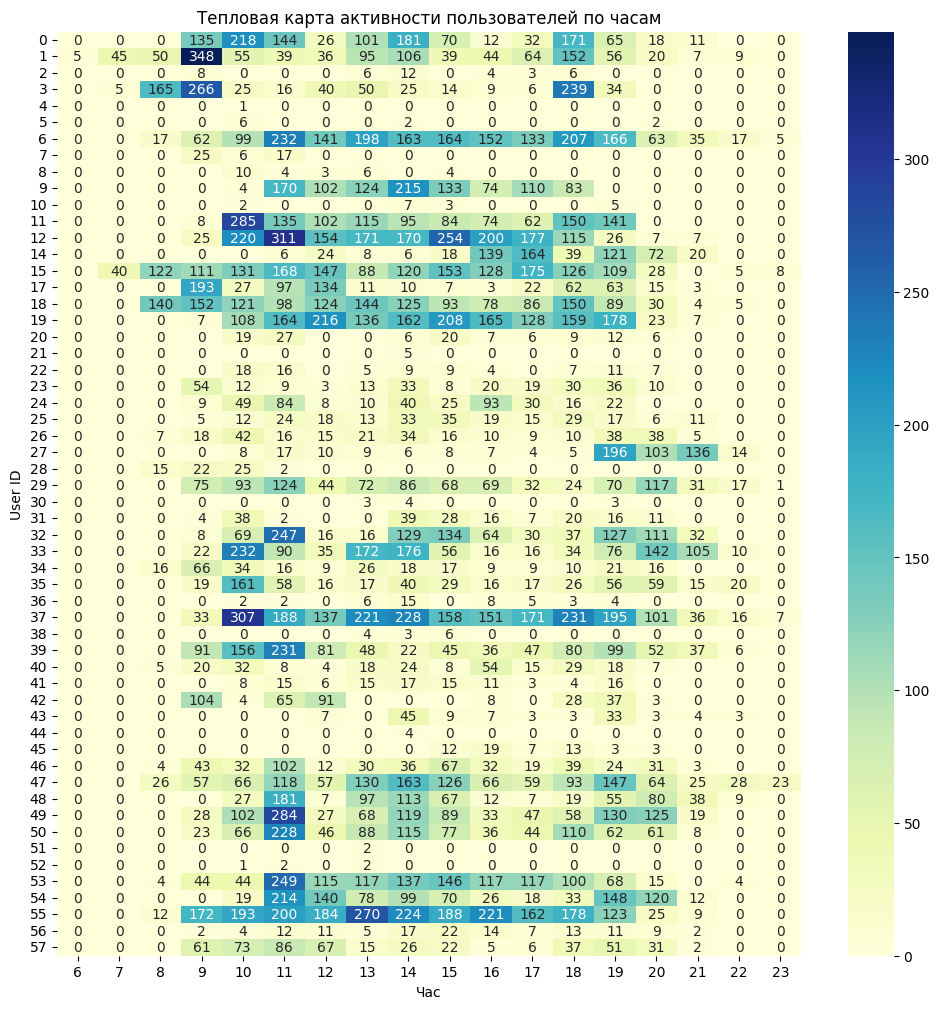

In [18]:
# Тепловая карта активности пользователей по часам
heatmap_data = df_train.pivot_table(index='user_id', columns=df_train['ts'].dt.hour, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по часам')
plt.xlabel('Час')
plt.ylabel('User ID')
plt.show()

## test

In [19]:
# Загрузим тестовые данные
df_test = pd.read_csv('test.csv', index_col=0)
df_test

,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


In [20]:
df_test.shape

(7125, 3)

In [21]:
df_test.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ts         7125 non-null   object
 1   gate_id    7125 non-null   int64 
 2   user_word  7125 non-null   object
dtypes: int64(1), object(2)
memory usage: 222.7+ KB


In [22]:
# Поиск дубликатов
columns_except_user_word = df_test.columns[df_test.columns != 'user_word'].tolist()
df_test[df_test.duplicated(keep='first')].sort_values(by=columns_except_user_word)

,ts,gate_id,user_word
37519,2023-01-03 08:21:00,9,gini
37525,2023-01-03 08:36:02,9,epsilon
37541,2023-01-03 09:31:09,9,epsilon
37560,2023-01-03 10:45:10,9,f1
37562,2023-01-03 10:45:22,5,f1
...,...,...,...
44616,2023-02-24 10:18:55,9,recall
44624,2023-02-24 11:21:18,9,recall
44627,2023-02-24 12:01:35,9,categorical
44635,2023-02-24 14:03:47,9,categorical


В тестовых данных также присутствуют дубликаты, которые мы удалим.

In [23]:
# Удалим дубликаты из test
columns_except_user_word = df_test.columns[df_test.columns != 'user_word'].tolist()
df_test = df_test.drop_duplicates(subset=columns_except_user_word, keep='first')

In [24]:
print('Количество уникальных gate_id в test:', df_test['gate_id'].nunique())
sorted(df_test['gate_id'].unique())

Количество уникальных gate_id в test: 16


[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [25]:
print('Количество уникальных user_word в test:', df_test['user_word'].nunique())
print(sorted(df_test['user_word'].unique()))

Количество уникальных user_word в test: 34
['aucroc', 'binary', 'blue', 'categorical', 'coefficient', 'collinear', 'distributed', 'epsilon', 'f1', 'fit', 'gini', 'independent', 'lasso', 'linear', 'logistic', 'loss', 'matrix', 'minimization', 'mse', 'ols', 'precision', 'predict', 'pvalue', 'r2', 'recall', 'regression', 'residual', 'ridge', 'sigmoid', 'significant', 'target', 'tstat', 'x', 'y']


Учитывая факт:
Количество уникальных user_id в train: 56
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]

И судя по описанию задания: "Максимум могут отсутствовать 10% id", следовательно id которых нет это могут быть 13, 16, 58.

In [26]:
# Подсчитываем количество записей для каждого user_word
count_df = df_test['user_word'].value_counts().reset_index()
count_df.columns = ['user_word', 'count']
sorted_count_df = count_df.sort_values(by='count', ascending=False)
sorted_count_df

,user_word,count
0,f1,692
1,loss,458
2,sigmoid,432
3,binary,362
4,epsilon,336
5,collinear,298
6,x,298
7,independent,278
8,significant,277
9,gini,253


### Графики

Аналогичные графики строим и для тестовых данных.

In [27]:
df_test['ts'] = pd.to_datetime(df_test['ts'])

In [28]:
# unique_users = df_test['user_word'].unique()
# unique_users.sort()

# fig, axes = plt.subplots(len(unique_users), 1, figsize=(20, 6 * len(unique_users)), sharex=True)

# for ax, user_word in zip(axes, unique_users):
#     user_data = df_test[df_test['user_word'] == user_word]
#     ax.plot(user_data['ts'], user_data['gate_id'], marker='o', label=f'User {user_word}')
#     ax.set_xlabel('Timestamp')
#     ax.set_ylabel('Gate ID')
#     ax.set_title(f'Зависимость между ts и gate_id для User {user_word}')
#     ax.legend()
#     ax.grid(True)

# plt.tight_layout()
# plt.show()

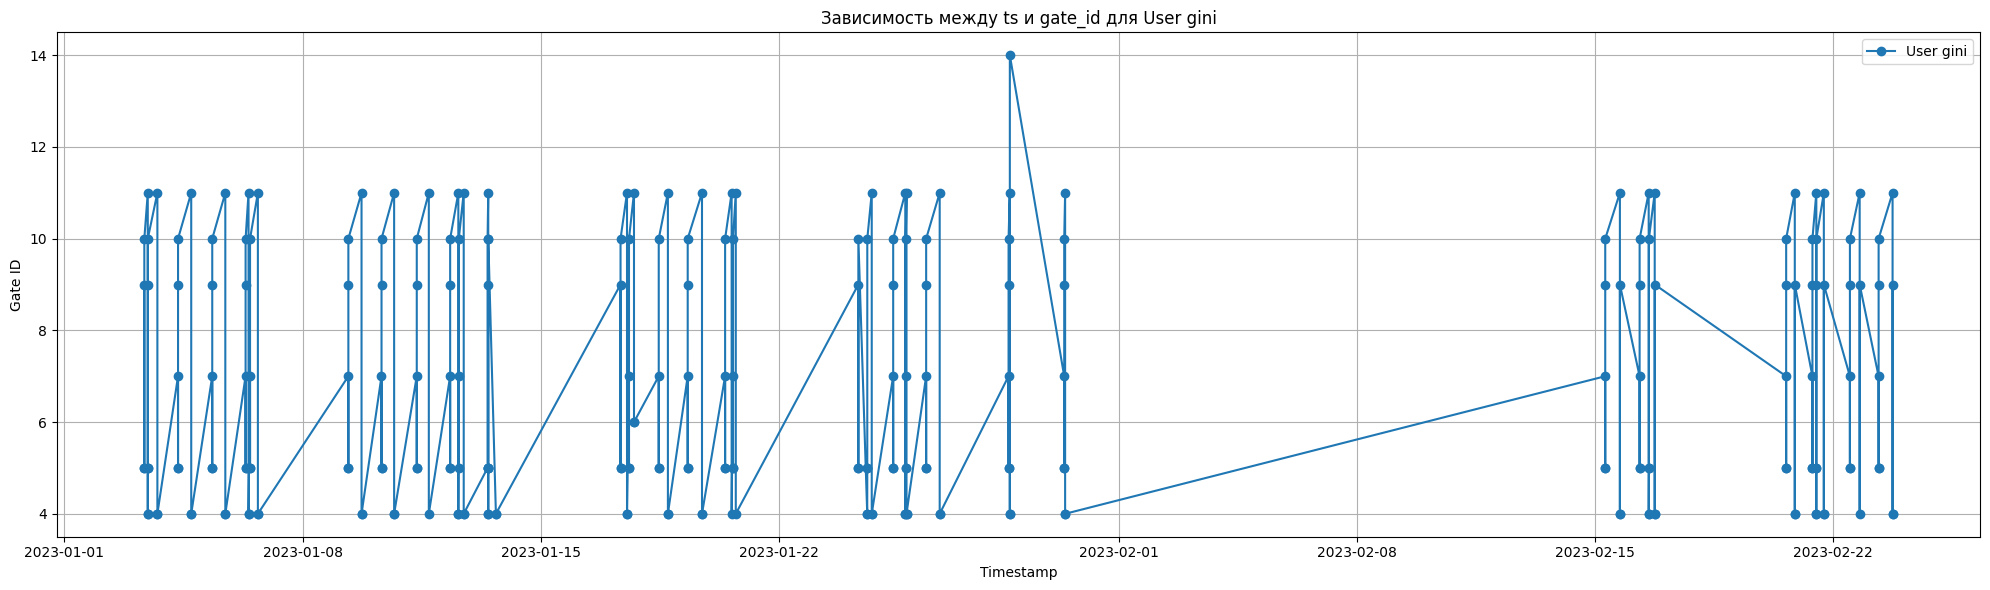

In [29]:
# Построим график передвижений для первого user_word
unique_users = df_test['user_word'].unique()
first_user_word = unique_users[0]

fig, ax = plt.subplots(figsize=(20, 6))

user_data = df_test[df_test['user_word'] == first_user_word]
ax.plot(user_data['ts'], user_data['gate_id'], marker='o', label=f'User {first_user_word}')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Gate ID')
ax.set_title(f'Зависимость между ts и gate_id для User {first_user_word}')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

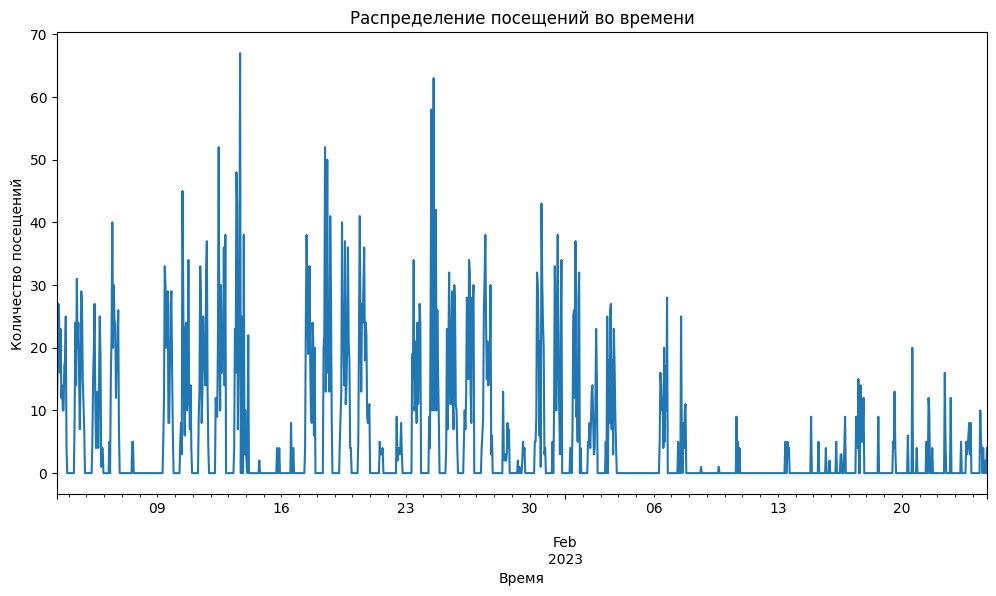

In [30]:
plt.figure(figsize=(12, 6))
df_test.set_index('ts').resample('H').size().plot()
plt.title('Распределение посещений во времени')
plt.xlabel('Время')
plt.ylabel('Количество посещений')
plt.show()

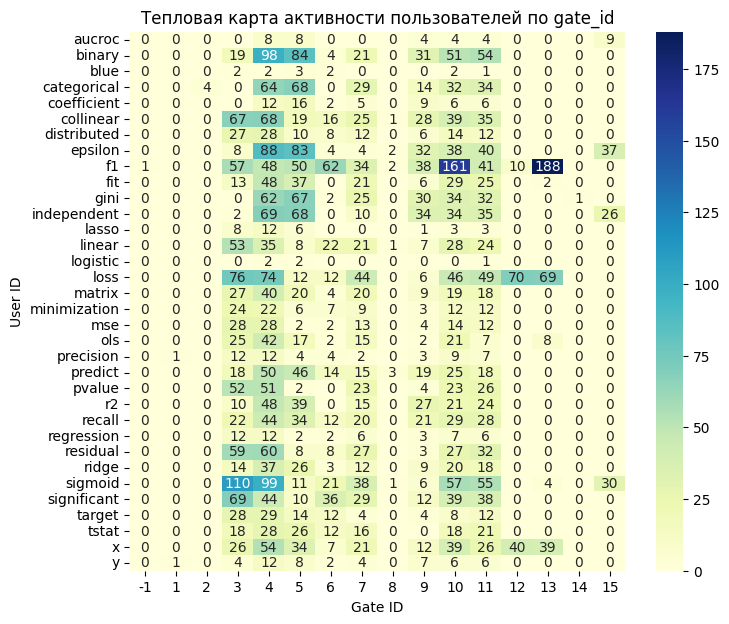

In [31]:
heatmap_data_gate = df_test.pivot_table(index='user_word', columns='gate_id', values='ts', aggfunc='count', fill_value=0)
plt.figure(figsize=(8, 7))
sns.heatmap(heatmap_data_gate, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по gate_id')
plt.xlabel('Gate ID')
plt.ylabel('User ID')
plt.show()

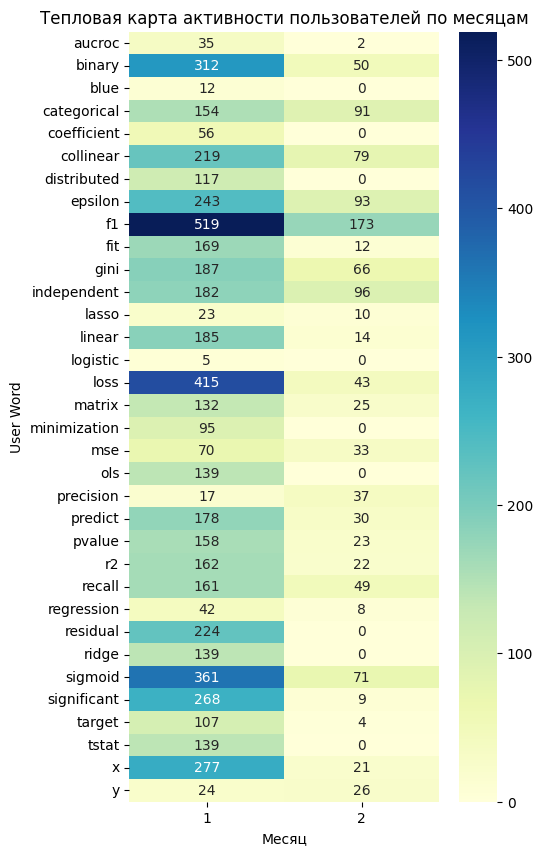

In [32]:
heatmap_data_month = df_test.pivot_table(index='user_word', columns=df_test['ts'].dt.month, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(5, 10))
sns.heatmap(heatmap_data_month, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('User Word')
plt.show()

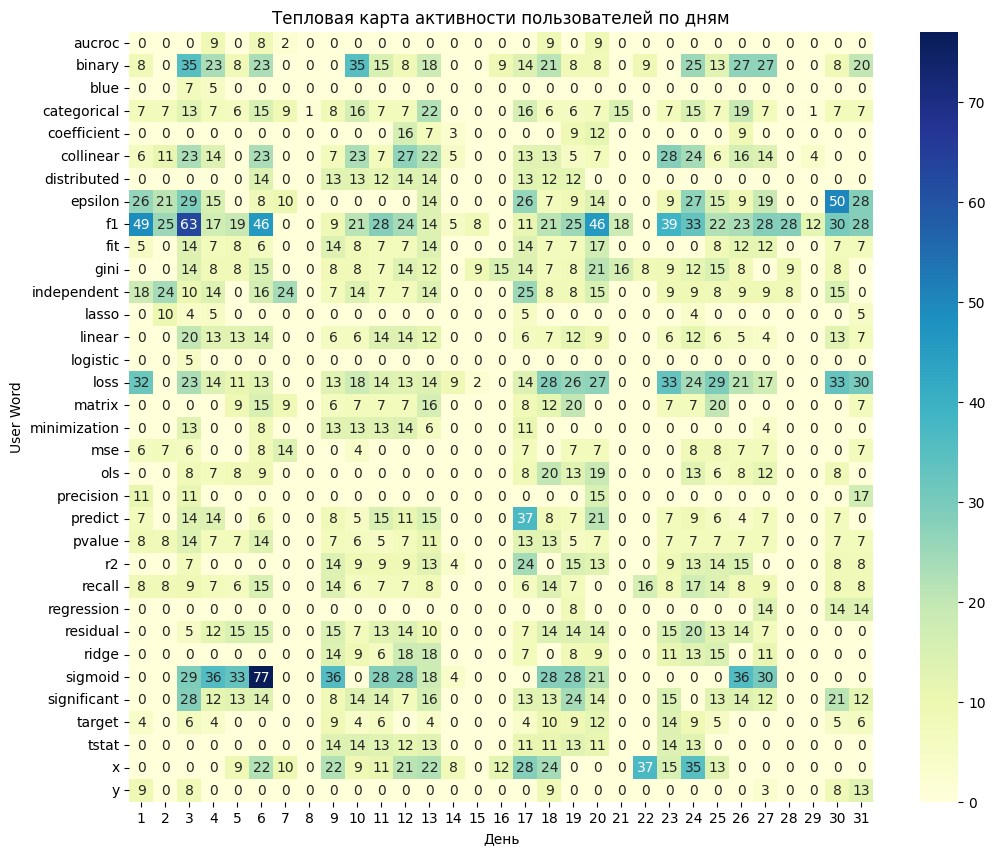

In [33]:
heatmap_data_day = df_test.pivot_table(index='user_word', columns=df_test['ts'].dt.day, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data_day, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по дням')
plt.xlabel('День')
plt.ylabel('User Word')
plt.show()

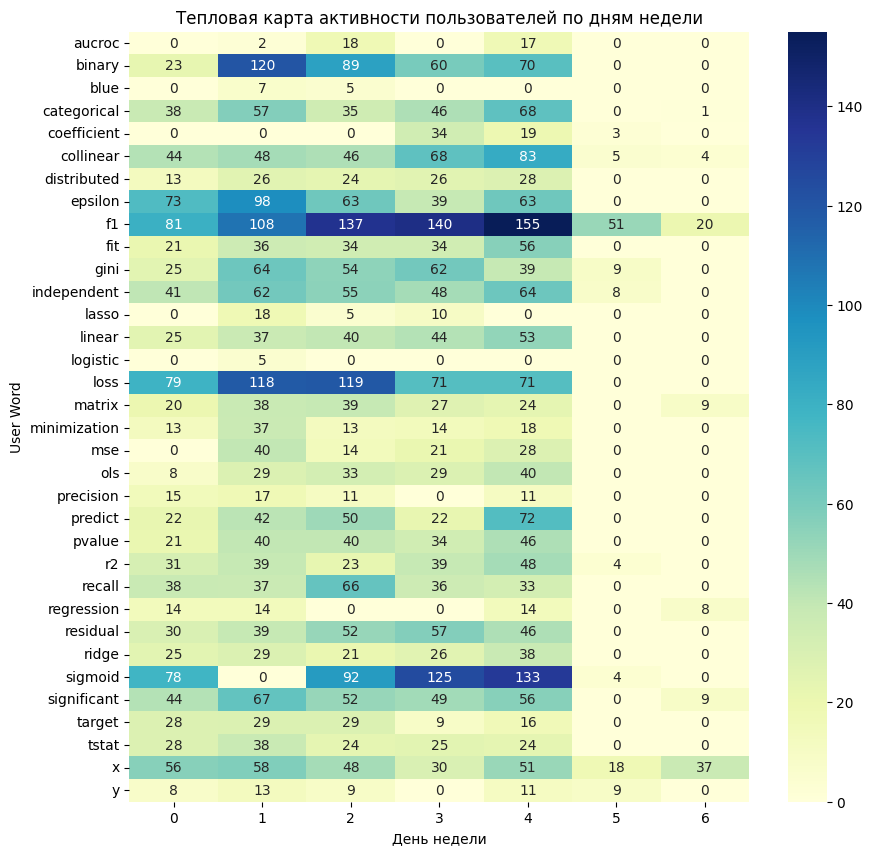

In [34]:
heatmap_data_weekday = df_test.pivot_table(index='user_word', columns=df_test['ts'].dt.dayofweek, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data_weekday, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по дням недели')
plt.xlabel('День недели')
plt.ylabel('User Word')
plt.show()

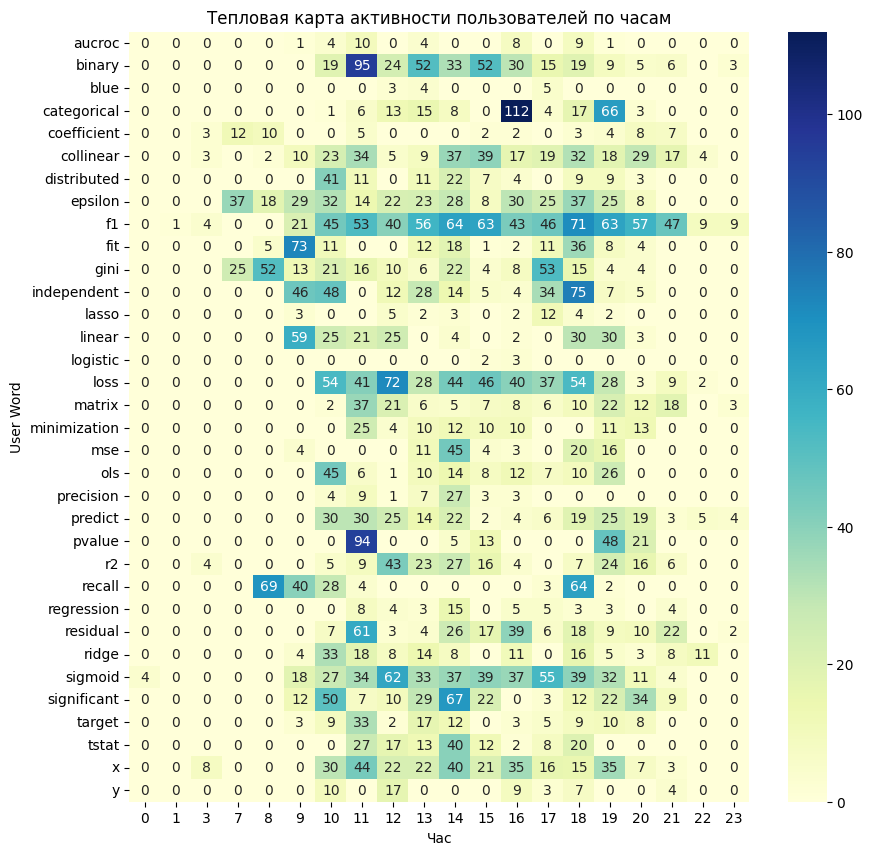

In [35]:
heatmap_data = df_test.pivot_table(index='user_word', columns=df_test['ts'].dt.hour, values='gate_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Тепловая карта активности пользователей по часам')
plt.xlabel('Час')
plt.ylabel('User Word')
plt.show()

## Различия по gate_id в данных

Проверим, есть ли различия в данных по gate_id

In [36]:
print('gate_id, которые есть только в train:',[gate for gate in sorted(list(df_train['gate_id'].unique())) if gate not in sorted(list(df_test['gate_id'].unique()))])

gate_id, которые есть только в train: [0, 16]


In [37]:
df_train[df_train['gate_id']==0]

,user_id,ts,gate_id
12652,25,2022-09-06 11:16:28,0
12653,25,2022-09-06 11:16:36,0


In [38]:
df_train[df_train['gate_id']==16]

,user_id,ts,gate_id
21309,25,2022-10-07 16:44:37,16
21310,25,2022-10-07 16:44:38,16
36798,56,2022-12-28 14:49:51,16
36799,21,2022-12-28 14:49:54,16


In [39]:
print('gate_id, которые есть только в test:',[gate for gate in sorted(list(df_test['gate_id'].unique())) if gate not in sorted(list(df_train['gate_id'].unique()))])

gate_id, которые есть только в test: [2]


In [40]:
df_test[df_test['gate_id']==2]

,ts,gate_id,user_word
39911,2023-01-13 16:49:52,2,categorical
39912,2023-01-13 16:49:54,2,categorical
39928,2023-01-13 18:21:16,2,categorical
39929,2023-01-13 18:21:19,2,categorical


## Выводы после анализа данных

1. Так как в данных у нас вероятно есть новые пользователи, то логично выдвинуть гипотезу, что новички среди тех у кого меньше всего записей. Так как обычно, выборка должна быть минимум 100, чтобы результаты были статистически значимыми и надежными, то гипотеза в том, что новые юзеры были среди тех, у кого число записей меньше 100, а именно: minimization, coefficient, precision, regression, y, aucroc, lasso, blue, logistic. С помощю такого подхода были выявлены новые юзеры под словами regression и y. Для них в дальнейшем будет присвоино значение -999. Также интересным моментом является тот факт, что у них одинаковое количество проходов.

In [41]:
filtered_df = sorted_count_df[sorted_count_df['count'] < 100]
filtered_df

,user_word,count
25,minimization,95
26,coefficient,56
27,precision,54
28,regression,50
29,y,50
30,aucroc,37
31,lasso,33
32,blue,12
33,logistic,5


2. По матрицам активности в часах, мы можем заметить, что в 7 утра чаще всего на трейне приходит user_id==1, а на тесте user_word==epsilon. Поэтому была гипотеза, что epsilon==1, ибо в любой компании всегда есть человек, который приходит всегда раньше всех из-за своей должности или по причине своего места проживания. Эта гипотеза также возникла у меня по причине, что у меня есть одногруппник, который уже 3 года держит планку, как человек, который всегда приходит первый на пары. С помощью лидерборда гипотеза подтвердилась + модель в дальнейшем каждый раз предсказывала epsilon==1.

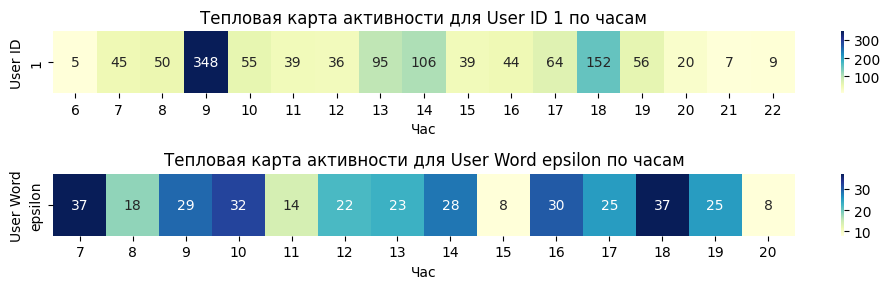

In [42]:
heatmap_data_user_id = df_train[df_train['user_id'] == 1].pivot_table(index='user_id', columns=df_train['ts'].dt.hour,
                                                                      values='gate_id', aggfunc='count', fill_value=0)

heatmap_data_user_word = df_test[df_test['user_word'] == 'epsilon'].pivot_table(
    index='user_word', columns=df_test['ts'].dt.hour, values='gate_id', aggfunc='count', fill_value=0
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3))

sns.heatmap(heatmap_data_user_id, cmap='YlGnBu', annot=True, fmt="d", ax=ax1)
ax1.set_title('Тепловая карта активности для User ID 1 по часам')
ax1.set_xlabel('Час')
ax1.set_ylabel('User ID')

sns.heatmap(heatmap_data_user_word, cmap='YlGnBu', annot=True, fmt="d", ax=ax2)
ax2.set_title('Тепловая карта активности для User Word epsilon по часам')
ax2.set_xlabel('Час')
ax2.set_ylabel('User Word')

plt.tight_layout()
plt.show()

3. Из тепловых карт пользователей по gate_id была выявлена закономерность в частоте проходов через определённые турникеты, а именно через 3, 4, 15. Таким образом появилась гипотеза, что sigmoid = 55.0. С помощью лидерборда гипотеза подтвердилась + модель в дальнейшем каждый раз предсказывала также.

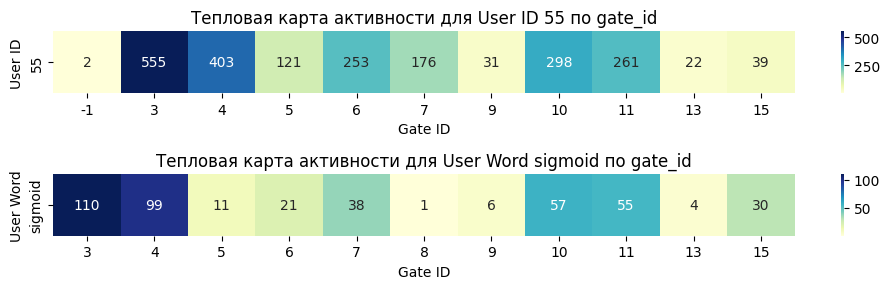

In [43]:
heatmap_data_user_id = df_train[df_train['user_id'] == 55].pivot_table(index='user_id', columns='gate_id',
                                                                       values='ts', aggfunc='count', fill_value=0)

heatmap_data_user_word = df_test[df_test['user_word'] == 'sigmoid'].pivot_table(index='user_word', columns='gate_id',
                                                                                values='ts', aggfunc='count', fill_value=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3))

sns.heatmap(heatmap_data_user_id, cmap='YlGnBu', annot=True, fmt="d", ax=ax1)
ax1.set_title('Тепловая карта активности для User ID 55 по gate_id')
ax1.set_xlabel('Gate ID')
ax1.set_ylabel('User ID')

sns.heatmap(heatmap_data_user_word, cmap='YlGnBu', annot=True, fmt="d", ax=ax2)
ax2.set_title('Тепловая карта активности для User Word sigmoid по gate_id')
ax2.set_xlabel('Gate ID')
ax2.set_ylabel('User Word')

plt.tight_layout()
plt.show()

4. В тесте у нас всего одна запись с 'gate_id'==-1. Была идея попробовать вычислить по этому gate_id верный user_id для user_word==f1. Учитывая, что у нас всего несколько записей в трейне, где для одного id запись также одна по gate_id==-1, было решено рассмотреть следующие id: 1, 6, 11, 23, 26, 29. В ходе подбора было выявлено, что для f1 соответствует значение равное 6 + модель в дальнейшем также предсказывала.

In [44]:
df_train[df_train['gate_id']==-1]

,user_id,ts,gate_id
329,46,2022-07-29 15:40:13,-1
331,46,2022-07-29 15:40:16,-1
333,46,2022-07-29 15:51:47,-1
8162,46,2022-08-22 15:29:12,-1
11858,56,2022-09-02 15:29:33,-1
11860,56,2022-09-02 15:29:42,-1
11862,56,2022-09-02 15:29:58,-1
11929,36,2022-09-02 16:45:58,-1
11931,36,2022-09-02 16:46:02,-1
12741,6,2022-09-06 14:46:12,-1


In [45]:
df_test[df_test['gate_id']==-1]

,ts,gate_id,user_word
43341,2023-01-31 15:51:37,-1,f1


5. Так как у нас на тесте 34 слова, а на трейне 56 айдишников, то логично можно предположить, что в трейне есть ненужные данные - лишние id. Так как обычно, выборка должна быть минимум 100, чтобы результаты были статистически значимыми и надежными, и модель наврятли сможет выявить какие-то закономерности в малом количестве данных, то было решено исключить id, где меньше 100 записей.

In [46]:
# Оставим только те user_id, у которых записей 100 и больше
user_counts = df_train['user_id'].value_counts()
valid_users = user_counts[user_counts >= 100].index
df_train = df_train[df_train['user_id'].isin(valid_users)]

print('Количество уникальных user_id в train:', df_train['user_id'].nunique())
print(sorted(df_train['user_id'].unique()))

Количество уникальных user_id в train: 40
[0, 1, 3, 6, 9, 11, 12, 14, 15, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57]


6. На тепловых картах бьло замечено также, что где gate_id равен -1, 0, 1, 2, 14, 16 записей крайне мало. Поэтому было решено в дальнейшем удалить записи связанные с ними, чтобы модель больше сосредоточилась на других данных.

7. Так как с помощью визуализации и анализа данных, были нйдены уже некоторые слова, то было решено исключить из обучающей выборки use_id==[1, 6, 55]. Но на валидации модель показала, что только удаление user_id==1 приносит улучшение результата, поэтому было решено удалять только его.

## submit

In [47]:
# Загрузим сабмит для примера
df_submit = pd.read_csv('submit.csv', index_col=0)
df_submit

,preds
user_word,
aucroc,49
binary,12
blue,55
categorical,14
coefficient,15
collinear,12
distributed,12
epsilon,1
f1,37


In [48]:
df_submit.shape

(34, 1)

In [49]:
df_submit.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, aucroc to y
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   preds   34 non-null     int64
dtypes: int64(1)
memory usage: 544.0+ bytes


# Предобработка данных

In [50]:
# Удаление всех записей, где user_id == 1
df_train = df_train[df_train['user_id'] != 1]

In [51]:
# Соединим данные для удобства предобработки
all_data = pd.concat([df_train, df_test], axis=0)
all_data

,user_id,ts,gate_id,user_word
0,18.0,2022-07-29 09:08:54,7,NaN
1,18.0,2022-07-29 09:09:54,9,NaN
3,18.0,2022-07-29 09:10:06,5,NaN
4,18.0,2022-07-29 09:10:08,5,NaN
5,18.0,2022-07-29 09:10:34,10,NaN
...,...,...,...,...
44637,NaN,2023-02-24 17:08:57,10,collinear
44638,NaN,2023-02-24 19:43:36,11,collinear
44639,NaN,2023-02-24 19:44:00,4,collinear
44640,NaN,2023-02-24 19:44:01,4,collinear


In [52]:
# Удаляем записи, где gate_id равен -1, 0, 1, 2, 14, 16
all_data = all_data[~all_data['gate_id'].isin([-1, 0, 1, 2, 14, 16])]

In [53]:
# Приводим ts к datetime
all_data['ts'] = pd.to_datetime(all_data['ts'])

In [54]:
# Сделаем gate_id категориальным
all_data['gate_id'] = all_data['gate_id'].astype('str')

In [55]:
# Создаём признаки из ts
all_data['Hour'] = all_data['ts'].dt.hour
all_data['Minute'] = all_data['ts'].dt.minute
all_data['Month'] = all_data['ts'].dt.month
all_data['Day'] = all_data['ts'].dt.day
all_data['DayOfWeek'] = all_data['ts'].dt.dayofweek

In [56]:
# Создадим признак времени в секундах
all_data['seconds_since_midnight'] = all_data['ts'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

In [57]:
# Создадим признак, содержащий какой по счёту был в день проход
all_data['record_number'] = all_data.groupby(all_data['ts'].dt.date).cumcount() + 1

In [58]:
# Создадим признак, содержащий какой по счёту был в день проход для юзера
all_data['record_number_per_user_per_day'] = all_data.groupby(['user_id', all_data['ts'].dt.date]).cumcount() + 1

In [59]:
# Создадим признак интервального времени
def time_of_day(hour):
    if 0 <= hour < 6:
        return 'Ночь'
    elif 6 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 14:
        return 'Обед'
    elif 14 <= hour < 17:
        return 'День'
    elif 17 <= hour < 18:
        return 'Пиковый час'
    elif 18 <= hour < 21:
        return 'Вечер'
    else:
        return 'Поздний вечер'

all_data['time_of_day'] = all_data['ts'].dt.hour.apply(time_of_day)

In [60]:
# Создадим признак показывающий какой сегодня день: выходной или нет
all_data['is_weekend'] = all_data['ts'].dt.dayofweek >= 5
all_data['is_weekend'] = all_data['is_weekend'].astype(int)

In [61]:
# Создадим признак с количеством проходов через тот или иной gate_id в день
all_data['date'] = all_data['ts'].dt.date
count_passages_user = all_data.groupby(['user_id', 'date', 'gate_id']).size().reset_index(name='pass_count')
all_data = all_data.merge(count_passages_user, on=['user_id', 'date', 'gate_id'], how='left')
count_passages_word = all_data.groupby(['user_word', 'date', 'gate_id']).size().reset_index(name='pass_count')
all_data = all_data.merge(count_passages_word, on=['user_word', 'date', 'gate_id'], how='left', suffixes=('', '_word'))
all_data['pass_count'] = all_data['pass_count_word'].fillna(all_data['pass_count'])
all_data.drop(columns=['pass_count_word'], inplace=True)

In [62]:
# Создадим признаки первого и посдеднего gate_id для пользователя в день
first_gate = all_data.groupby(['user_id', 'date'])['gate_id'].first().reset_index()
last_gate = all_data.groupby(['user_id', 'date'])['gate_id'].last().reset_index()
result = pd.merge(first_gate, last_gate, on=['user_id', 'date'], suffixes=('_first', '_last'))
all_data = pd.merge(all_data, result, on=['user_id', 'date'], how='left')
first_gate_word = all_data.groupby(['user_word', 'date'])['gate_id'].first().reset_index()
last_gate_word = all_data.groupby(['user_word', 'date'])['gate_id'].last().reset_index()
result_word = pd.merge(first_gate_word, last_gate_word, on=['user_word', 'date'], suffixes=('_first', '_last'))
all_data = pd.merge(all_data, result_word, on=['user_word', 'date'], how='left', suffixes=('', '_word'))
all_data['gate_id_first'] = all_data['gate_id_first'].fillna(all_data['gate_id_first_word'])
all_data['gate_id_last'] = all_data['gate_id_last'].fillna(all_data['gate_id_last_word'])
all_data.drop(columns=['gate_id_first_word', 'gate_id_last_word'], inplace=True)
cols_to_convert = [col for col in all_data.columns if 'prev_' in col or 'next_' in col]
all_data[cols_to_convert] = all_data[cols_to_convert].astype('str')

Было решено создать признаки, которые будут содержать информацию о предыдущих и последующих турникетах, а также разницу во времени прохода между ними в секнудах. Изначально были только признаки предыдщуего и последующего gate_id и они хорошо показывали себя на валидации, поэтому было решено попробовать добавить ещё сдвиги. Но также во время валидации выяснилось, что при большем значении свдигов модель начинала переобучаться, поэтому эмпирическим путём было выбрано число сдвигов 4.

In [63]:
def add_shifted_columns(df, group_col, target_col, shifts):
    for shift in shifts:
        df[f'prev_{shift}_{target_col}_{group_col}'] = df.groupby(group_col)[target_col].shift(shift)
        df[f'next_{shift}_{target_col}_{group_col}'] = df.groupby(group_col)[target_col].shift(-shift)
    return df

shifts = list(range(1, 5))
all_data = add_shifted_columns(all_data, 'user_id', 'gate_id', shifts)
all_data = add_shifted_columns(all_data, 'user_word', 'gate_id', shifts)

for shift in shifts:
    all_data[f'prev_{shift}_gate_id'] = all_data[f'prev_{shift}_gate_id_user_id'].combine_first(all_data[f'prev_{shift}_gate_id_user_word'])
    all_data[f'next_{shift}_gate_id'] = all_data[f'next_{shift}_gate_id_user_id'].combine_first(all_data[f'next_{shift}_gate_id_user_word'])

cols_to_drop = [f'prev_{shift}_gate_id_user_id' for shift in shifts] + [f'next_{shift}_gate_id_user_id' for shift in shifts] + [f'prev_{shift}_gate_id_user_word' for shift in shifts] + [f'next_{shift}_gate_id_user_word' for shift in shifts]
all_data = all_data.drop(columns=cols_to_drop)

In [64]:
def add_time_diff_columns(df, group_col, time_col, shifts):
    for shift in shifts:
        df[f'prev_{shift}_time_diff_{group_col}'] = (df[time_col] - df.groupby(group_col)[time_col].shift(shift)).dt.total_seconds()
        df[f'next_{shift}_time_diff_{group_col}'] = (df.groupby(group_col)[time_col].shift(-shift) - df[time_col]).dt.total_seconds()
    return df

all_data = add_time_diff_columns(all_data, 'user_id', 'ts', shifts)
all_data = add_time_diff_columns(all_data, 'user_word', 'ts', shifts)

for shift in shifts:
    all_data[f'prev_{shift}_time_diff'] = all_data[f'prev_{shift}_time_diff_user_id'].combine_first(all_data[f'prev_{shift}_time_diff_user_word'])
    all_data[f'next_{shift}_time_diff'] = all_data[f'next_{shift}_time_diff_user_id'].combine_first(all_data[f'next_{shift}_time_diff_user_word'])

cols_to_drop_time = [f'prev_{shift}_time_diff_user_id' for shift in shifts] + [f'next_{shift}_time_diff_user_id' for shift in shifts] + [f'prev_{shift}_time_diff_user_word' for shift in shifts] + [f'next_{shift}_time_diff_user_word' for shift in shifts]
all_data = all_data.drop(columns=cols_to_drop_time)

In [65]:
cols_to_convert = [f'prev_{shift}_gate_id' for shift in shifts] + [f'next_{shift}_gate_id' for shift in shifts]
all_data[cols_to_convert] = all_data[cols_to_convert].astype('str')
all_data.drop(columns=['date'], inplace=True, errors='ignore')

## Итоговые данные

In [66]:
all_data.head(20)

,user_id,ts,gate_id,user_word,Hour,Minute,Month,Day,DayOfWeek,seconds_since_midnight,record_number,record_number_per_user_per_day,time_of_day,is_weekend,pass_count,gate_id_first,gate_id_last,prev_1_gate_id,next_1_gate_id,prev_2_gate_id,next_2_gate_id,prev_3_gate_id,next_3_gate_id,prev_4_gate_id,next_4_gate_id,prev_1_time_diff,next_1_time_diff,prev_2_time_diff,next_2_time_diff,prev_3_time_diff,next_3_time_diff,prev_4_time_diff,next_4_time_diff
0,18.0,2022-07-29 09:08:54,7,NaN,9,8,7,29,4,32934,1,1.0,Утро,0,6.0,7,9,nan,9,nan,5,nan,5,nan,10,NaN,60.0,NaN,72.0,NaN,74.0,NaN,100.0
1,18.0,2022-07-29 09:09:54,9,NaN,9,9,7,29,4,32994,2,2.0,Утро,0,3.0,7,9,7,5,nan,5,nan,10,nan,11,60.0,12.0,NaN,14.0,NaN,40.0,NaN,1373.0
2,18.0,2022-07-29 09:10:06,5,NaN,9,10,7,29,4,33006,3,3.0,Утро,0,14.0,7,9,9,5,7,10,nan,11,nan,4,12.0,2.0,72.0,28.0,NaN,1361.0,NaN,1386.0
3,18.0,2022-07-29 09:10:08,5,NaN,9,10,7,29,4,33008,4,4.0,Утро,0,14.0,7,9,5,10,9,11,7,4,nan,4,2.0,26.0,14.0,1359.0,74.0,1384.0,NaN,1385.0
4,18.0,2022-07-29 09:10:34,10,NaN,9,10,7,29,4,33034,5,5.0,Утро,0,6.0,7,9,5,11,5,4,9,4,7,9,26.0,1333.0,28.0,1358.0,40.0,1359.0,100.0,1369.0
5,18.0,2022-07-29 09:32:47,11,NaN,9,32,7,29,4,34367,6,6.0,Утро,0,4.0,7,9,10,4,5,4,5,9,9,5,1333.0,25.0,1359.0,26.0,1361.0,36.0,1373.0,54.0
6,18.0,2022-07-29 09:33:12,4,NaN,9,33,7,29,4,34392,7,7.0,Утро,0,16.0,7,9,11,4,10,9,5,5,5,5,25.0,1.0,1358.0,11.0,1384.0,29.0,1386.0,30.0
7,18.0,2022-07-29 09:33:13,4,NaN,9,33,7,29,4,34393,8,8.0,Утро,0,16.0,7,9,4,9,11,5,10,5,5,10,1.0,10.0,26.0,28.0,1359.0,29.0,1385.0,51.0
8,18.0,2022-07-29 09:33:23,9,NaN,9,33,7,29,4,34403,9,9.0,Утро,0,3.0,7,9,4,5,4,5,11,10,10,12,10.0,18.0,11.0,19.0,36.0,41.0,1369.0,1388.0
9,18.0,2022-07-29 09:33:41,5,NaN,9,33,7,29,4,34421,10,10.0,Утро,0,14.0,7,9,9,5,4,10,4,12,11,12,18.0,1.0,28.0,23.0,29.0,1370.0,54.0,1372.0


In [67]:
all_data.shape

(40109, 33)

In [68]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40109 entries, 0 to 40108
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         33504 non-null  float64       
 1   ts                              40109 non-null  datetime64[ns]
 2   gate_id                         40109 non-null  object        
 3   user_word                       6605 non-null   object        
 4   Hour                            40109 non-null  int32         
 5   Minute                          40109 non-null  int32         
 6   Month                           40109 non-null  int32         
 7   Day                             40109 non-null  int32         
 8   DayOfWeek                       40109 non-null  int32         
 9   seconds_since_midnight          40109 non-null  int64         
 10  record_number                   40109 non-null  int64         
 11  re

In [69]:
all_data.isna().sum().sort_values(ascending=False)

user_word                         33504
user_id                            6605
record_number_per_user_per_day     6605
prev_4_time_diff                    292
next_4_time_diff                    292
next_3_time_diff                    219
prev_3_time_diff                    219
next_2_time_diff                    146
prev_2_time_diff                    146
next_1_time_diff                     73
prev_1_time_diff                     73
Minute                                0
Month                                 0
gate_id                               0
next_4_gate_id                        0
prev_4_gate_id                        0
next_3_gate_id                        0
prev_3_gate_id                        0
next_2_gate_id                        0
prev_2_gate_id                        0
next_1_gate_id                        0
prev_1_gate_id                        0
ts                                    0
gate_id_first                         0
pass_count                            0


# Разбиение данных

In [70]:
train_idx = all_data['user_word'].isnull()
train = all_data.loc[train_idx]
train = train.drop(columns='user_word')
test = all_data.loc[~train_idx]

In [71]:
train['ts'].agg(['min','max','count'])

min      2022-07-29 09:08:54
max      2022-12-31 20:39:31
count                  33504
Name: ts, dtype: object

In [72]:
test['ts'].agg(['min','max','count'])

min      2023-01-03 08:21:00
max      2023-02-24 19:44:09
count                   6605
Name: ts, dtype: object

In [73]:
val_index = train['ts'] > '2022-11-30'

In [74]:
X_train = train[~val_index].copy()
X_val = train[val_index].copy()

y = X_train['user_id'].astype(int)
y_val = X_val['user_id'].astype(int)

X_train = X_train.drop(columns='user_id')
X_val = X_val.drop(columns='user_id')

# Обучение модели

In [75]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['object']).columns]
categorical_features_indices

[1, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [76]:
train_pool_cat = Pool(
    data=X_train,
    label=y,
    cat_features=categorical_features_indices
)

In [77]:
# Посчитаем веса для классов, так как очевидно у нас присутствует дисбаланс
all_classes = np.setdiff1d(np.arange(0, 58), [13, 16])
valid_classes = np.intersect1d(all_classes, np.unique(y))

class_weights = compute_class_weight(class_weight='balanced', classes=valid_classes, y=y)
class_weights_dict = dict(zip(valid_classes, class_weights))
class_weights_dict

{0: 0.7824510307806521,
 3: 0.9827147211762597,
 6: 0.4444282262119074,
 9: 0.8048579904250007,
 11: 0.6949960688833092,
 12: 0.45655687176155013,
 14: 1.5789685969461251,
 15: 0.4862567651494987,
 17: 2.1686451408673633,
 18: 0.488623800863022,
 19: 0.5227983821733821,
 20: 6.273580586080586,
 23: 6.8886375062845655,
 24: 2.9034753125662216,
 25: 4.3372902817347265,
 26: 3.2529677113010447,
 27: 1.3434818845908711,
 29: 0.9482335028893734,
 31: 3.8819946168012467,
 32: 0.9233127800801914,
 33: 0.8170244484197973,
 34: 2.702465483234714,
 35: 2.7993666360200224,
 37: 0.39035612535612535,
 39: 0.8996684067106603,
 40: 2.9034753125662216,
 41: 24.2290008841733,
 42: 2.0665912518853697,
 43: 117.1068376068376,
 46: 2.1100331100331102,
 47: 0.5634651368412394,
 48: 0.988243355331963,
 49: 0.7563412547266153,
 50: 0.8579255502332426,
 53: 0.5506591110039386,
 54: 0.9281915794465332,
 55: 0.4544896672969118,
 56: 8.46555452579549,
 57: 1.46383547008547}

In [78]:
%%time

params = {
          'verbose': 200,
          'random_seed': 42,
          'task_type': 'GPU',
          'devices': '0',
          'class_weights': class_weights_dict,
          }

clf = CatBoostClassifier(**params)
clf.fit(train_pool_cat)

Learning rate set to 0.127525
0:	learn: 3.4384283	total: 50.5ms	remaining: 50.5s
200:	learn: 0.7648914	total: 8.5s	remaining: 33.8s
400:	learn: 0.4822130	total: 16.6s	remaining: 24.9s
600:	learn: 0.3494472	total: 24.7s	remaining: 16.4s
800:	learn: 0.2729644	total: 32.5s	remaining: 8.07s
999:	learn: 0.2208561	total: 40.2s	remaining: 0us
CPU times: total: 1min 28s
Wall time: 41.4 s


In [79]:
y_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

In [80]:
# Сделаем словарь для val, train, и превратим y_val (y) внабодобие того, который нужно предсказать
user_dict_val = dict() 
inverse_user_dict_val = dict()

y_val_list = list(y_val.unique())
for i in range(len(y_val_list)):
    user_dict_val[y_val_list[i]] = 'user_'+str(i)
    inverse_user_dict_val['user_'+str(i)] = y_val_list[i]

user_dict_train = dict() 
inverse_user_dict_train = dict()

y_train_list = list(y.unique())
for i in range(len(y_train_list)):
    user_dict_train[y_train_list[i]] = 'train_user_'+str(i)
    inverse_user_dict_train['train_user_'+str(i)] = y_train_list[i]

y_val_word = y_val.copy()

for y_val_id in y_val_list:
    y_val_word.loc[y_val == y_val_id] = user_dict_val[y_val_id]
    
y_word = y.copy()

for y_train_id in y_train_list:
    y_word.loc[y == y_train_id] = user_dict_train[y_train_id]

val_words = pd.DataFrame()

val_words['word'] = y_val_word
val_words['true'] = y_val
val_words['preds'] = y_val_pred

train_words = pd.DataFrame()

train_words['word'] = y_word
train_words['true'] = y
train_words['preds'] = y_pred

C:\Users\Professional\AppData\Local\Temp\ipykernel_3188\3783163601.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'user_0' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  y_val_word.loc[y_val == y_val_id] = user_dict_val[y_val_id]
C:\Users\Professional\AppData\Local\Temp\ipykernel_3188\3783163601.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train_user_0' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  y_word.loc[y == y_train_id] = user_dict_train[y_train_id]


In [81]:
val_words

,word,true,preds
27403,user_0,39,3
27404,user_0,39,3
27405,user_0,39,3
27406,user_0,39,3
27407,user_0,39,3
...,...,...,...
33499,user_15,6,6
33500,user_15,6,6
33501,user_15,6,6
33502,user_15,6,6


In [82]:
# Предскажем самым частотным user_id
comp_df = pd.DataFrame(val_words.groupby('word')['preds'].agg(lambda x: x.value_counts().index[0]))
comp_df_train = pd.DataFrame(train_words.groupby('word')['preds'].agg(lambda x: x.value_counts().index[0]))

In [83]:
for idx in comp_df.index:
    comp_df.loc[idx, 'true'] = inverse_user_dict_val[idx]
    
comp_df = comp_df.astype(int)

for idx in comp_df_train.index:
    comp_df_train.loc[idx, 'true'] = inverse_user_dict_train[idx]
    
comp_df_train = comp_df_train.astype(int)

In [84]:
comp_df

,preds,true
word,,
user_0,39,39
user_1,3,3
user_10,6,41
user_11,33,25
user_12,46,46
user_13,12,12
user_14,32,32
user_15,6,6
user_16,54,54


In [85]:
comp_df['comp'] = comp_df['preds'] == comp_df['true']
comp_df_train['comp'] = comp_df_train['preds'] == comp_df_train['true']
comp_df['norm'] = 1
comp_df_train['norm'] = 1

In [86]:
true_answers = (comp_df['comp'] * comp_df['norm']).sum()
total_answers = comp_df['norm'].sum()
precent_true = round((true_answers/total_answers)*100, 1)
print('Оценка val', true_answers, total_answers, precent_true)

Оценка val 17 33 51.5


In [87]:
true_answers_train = (comp_df_train['comp'] * comp_df_train['norm']).sum()
total_answers_train = comp_df_train['norm'].sum()
precent_true_train = round((true_answers_train/total_answers_train)*100, 1)
print('Оценка train', true_answers_train, total_answers_train, precent_true_train)

Оценка train 39 39 100.0


In [88]:
feature_importances = clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train),
                                       'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
0,ts,17.299933
14,gate_id_last,9.618198
7,seconds_since_midnight,8.193229
5,Day,6.277387
13,gate_id_first,5.820920
30,next_4_time_diff,5.702812
6,DayOfWeek,5.167758
29,prev_4_time_diff,4.790403
9,record_number_per_user_per_day,3.818644
3,Minute,3.296439


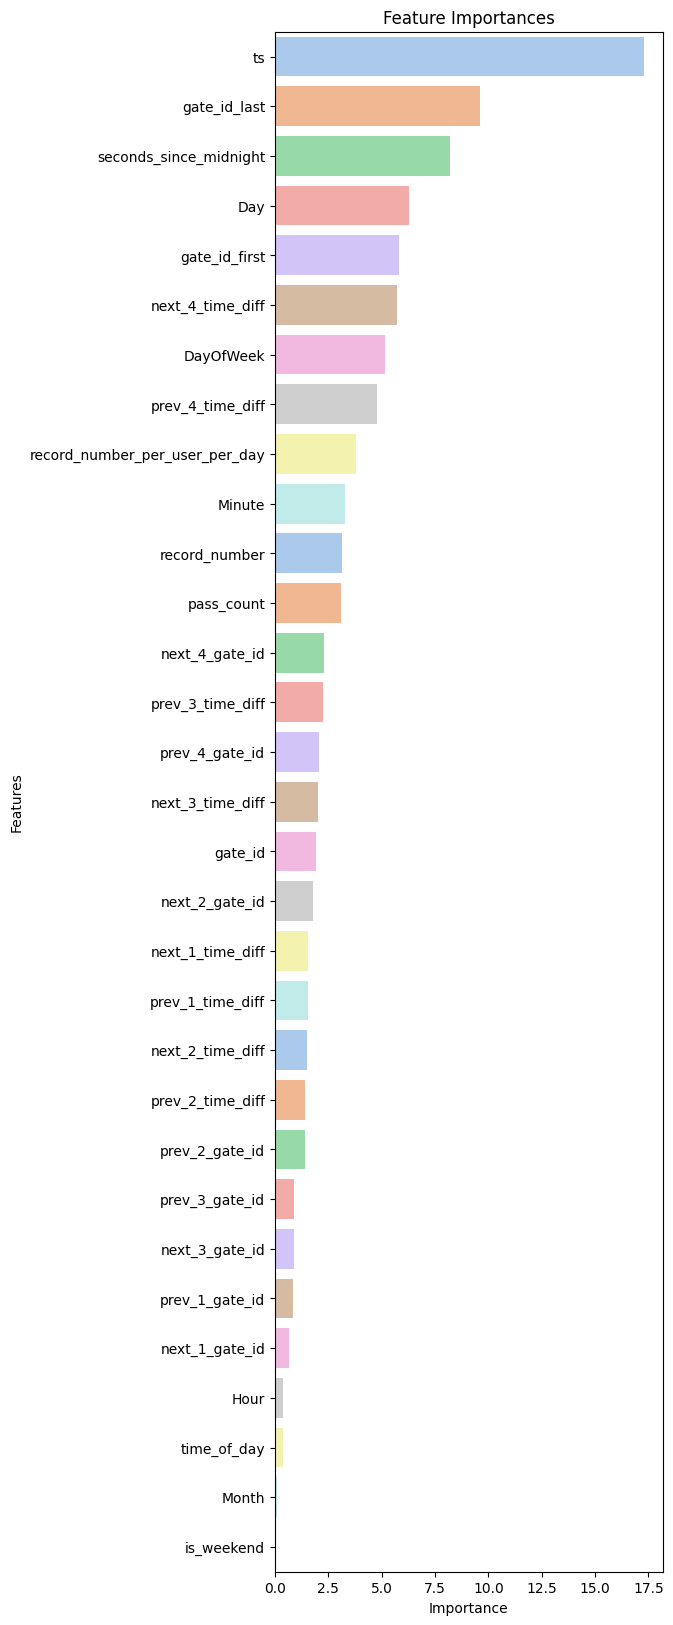

In [89]:
feature_importances = clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train.columns),
                                       'feature_importances': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(5, 20))
sns.barplot(x='feature_importances', y='features', data=feature_importances_df, palette='pastel')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Предсказание

Изначально я делал предсказание только с помощью Catboost, но потом вспомнил один момент: я участвовал в XIV  ШИФТ Интенсиве и наша команда в общем зачёте заняла второе место по ML Classic, а первое место у нас забрала команда благодаря Блендингу. Я решил не совершать одну ошибку дважды и попробовал блендинг на этих данных. За счёт блендинга я увеличил скор на лидерборде на 3 балла (было 344, стало 347). Разница не сущетсвенная прям, но решил его оставить, главное что меньше не стало :) 

In [90]:
X_train = train.drop(columns='user_id')
y_train = train['user_id']
X_test = test.drop(columns=['user_id', 'user_word'])

In [91]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['object']).columns]

train_pool_cat = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_features_indices
)

In [92]:
params_cat = {
    'verbose': 200,
    'random_seed': 42,
    'task_type': 'GPU',
    'devices': '0',
    'class_weights': compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train).tolist()
}

model_cat = CatBoostClassifier(**params_cat)
model_cat.fit(train_pool_cat)

Learning rate set to 0.132863
0:	learn: 3.4265219	total: 44.5ms	remaining: 44.4s
200:	learn: 0.8037446	total: 8.85s	remaining: 35.2s
400:	learn: 0.5120375	total: 17.3s	remaining: 25.9s
600:	learn: 0.3853706	total: 25.3s	remaining: 16.8s
800:	learn: 0.2988867	total: 33.4s	remaining: 8.29s
999:	learn: 0.2371736	total: 41.5s	remaining: 0us


In [93]:
# Получение предсказаний CatBoost на обучающих данных
train_preds = model_cat.predict_proba(X_train)

# Получение предсказаний CatBoost на тестовых данных
test_preds = model_cat.predict_proba(X_test)

In [94]:
# Создание мета-модели
meta_model = CatBoostClassifier(
    iterations=1000,
    verbose=200,
    random_seed=42,
    task_type='GPU',
    devices='0'
)

# Обучение мета-модели на предсказаниях CatBoost
meta_model.fit(train_preds, y_train)

Learning rate set to 0.132863
0:	learn: 2.6002763	total: 28.7ms	remaining: 28.6s
200:	learn: 0.0720684	total: 4.06s	remaining: 16.2s
400:	learn: 0.0344616	total: 8.09s	remaining: 12.1s
600:	learn: 0.0207700	total: 12.1s	remaining: 8.03s
800:	learn: 0.0141004	total: 16.1s	remaining: 4s
999:	learn: 0.0103692	total: 20.2s	remaining: 0us


In [95]:
# Предсказание с использованием мета-модели
final_preds_encoded = meta_model.predict(test_preds)

Также было решено изменить способ предсказания. Предскание самым частотным user_id несло за собой проблему, что один user_id предсказывался сразу нескольким user_word. Поэтому было решено присваивть user_id наиболее вероятному слову и чтобы в дальнейшем user_id данный не рассматривался, то есть если такой user_id занят, то рассматривается следующий по вероятности user_id.

In [96]:
test['preds_id'] = final_preds_encoded

In [97]:
# Замена значений на основании 'user_word'
test.loc[test['user_word'] == 'epsilon', 'preds_id'] = 1
test.loc[test['user_word'] == 'regression', 'preds_id'] = -999
test.loc[test['user_word'] == 'y', 'preds_id'] = -999

In [98]:
test.groupby('user_word')['preds_id'].agg(lambda x: x.mode()[0]).rename('preds').to_frame()

,preds
user_word,
aucroc,24.0
binary,12.0
blue,11.0
categorical,14.0
coefficient,15.0
collinear,33.0
distributed,0.0
epsilon,1.0
f1,6.0


In [99]:
result_probs = (
    test.groupby(['user_word', 'preds_id'])
    .size()
    .div(test.groupby('user_word').size(), level='user_word')
    .reset_index(name='probability')
)

sorted_probs = result_probs.sort_values('probability', ascending=False)

In [100]:
processed_words, processed_preds = set(), set()
mapping_list = []

for _, row in sorted_probs.iterrows():
    if row['user_word'] not in processed_words and row['preds_id'] not in processed_preds:
        mapping_list .append({'word': row['user_word'], 'preds': row['preds_id']})
        processed_words.add(row['user_word'])
        processed_preds.add(row['preds_id'])

# Также добавим цикл, что если для user_word не достался id, то присвоим -999. 
# Была гипотеза, что таким образом получится вычислить третьего новичка, но, к сожалению, она не выстрелила.
for word in sorted_probs['user_word'].unique():
    if word not in processed_words:
        mapping_list.append({'word': word, 'preds': -999})

mapping_list = pd.DataFrame(mapping_list).rename(columns={'word': 'user_word'}).set_index('user_word').sort_index()

In [101]:
mapping_list

,preds
user_word,
aucroc,24.0
binary,12.0
blue,-999.0
categorical,14.0
coefficient,-999.0
collinear,-999.0
distributed,0.0
epsilon,1.0
f1,6.0


In [102]:
mapping_list.shape[0]

34

In [103]:
# Выведем user_id, для которых не было предсказания
unique_train_ids = [0, 3, 6, 9, 11, 12, 14, 15, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 35, 37, 39,
                    40, 41, 42, 43, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57]
predicted_ids = mapping_list['preds'].unique()
unpredicted_ids = set(unique_train_ids) - set(predicted_ids)
print("user_id без предсказаний:", unpredicted_ids)

user_id без предсказаний: {34, 40, 41, 42, 47, 48, 18, 20, 53, 56, 57, 27, 31}


In [104]:
mapping_list.to_csv('answer.csv')

with zipfile.ZipFile('answer.zip', 'w') as myzip:
    myzip.write('answer.csv')

Итоги и выводы:
1. По итогу на лидерборде получается 347 баллов. Результат получился хороший, на мой взгляд. Но учитывая, что максимально 540 баллов, то, видимо, много над чем ещё нужно было подумать.
2. Единственное, что я не успел и хотел бы поробовать, так это перебрать гиперпараметры и сделать стекинг.

P.S. : Я не стал включать в ноутбук всё что я пробовал, по типу создание других признаков, удаление каких-то данных, гипотезы, которые не приносили результата, потому что ноутбук и так насыщенный, на мой взгляд, поэтому смысла перегружать его не вижу, да и Вам (комиссии) проще и быстрее будет проверять ;)